In [1]:
!pip install xgboost

from xgboost import XGBRegressor

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

In [3]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 5                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [4]:
overall_df = pd.read_csv('dataset.csv')
overall_df

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,...,Transactions_lag_4,Compound_lag_5,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5
0,2020-04-03 00:00:00,0.211225,6736.2,2.602287e+07,0.006667,5.76,3.63,750332,548300.0,278763.0,...,278763.0,0.211225,6736.2,2.602287e+07,0.006667,5.76,3.63,750332,548300.0,278763.0
1,2020-04-04 00:00:00,0.211225,6856.4,1.670837e+07,0.010000,5.14,3.90,657862,479599.0,253274.0,...,253274.0,0.211225,6856.4,1.670837e+07,0.010000,5.14,3.90,657862,479599.0,253274.0
2,2020-04-05 00:00:00,0.211225,6772.2,1.072203e+07,-0.003333,6.12,4.34,596364,452282.0,240259.0,...,240259.0,0.211225,6772.2,1.072203e+07,-0.003333,6.12,4.34,596364,452282.0,240259.0
3,2020-04-06 00:00:00,0.211225,7329.5,1.912836e+07,0.000000,8.09,5.10,780832,557192.0,280470.0,...,280470.0,0.211225,7329.5,1.912836e+07,0.000000,8.09,5.10,780832,557192.0,280470.0
4,2020-04-07 00:00:00,0.211225,7197.9,2.771690e+07,-0.006667,8.29,5.10,938358,598670.0,312770.0,...,312770.0,0.211225,7197.9,2.771690e+07,-0.006667,8.29,5.10,938358,598670.0,312770.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2022-02-27 00:00:00,0.106867,37706.7,3.883689e+08,0.006667,12.96,21.07,768705,583361.0,211164.0,...,211164.0,0.106867,37706.7,3.883689e+08,0.006667,12.96,21.07,768705,583361.0,211164.0
696,2022-02-28 00:00:00,0.135383,43179.8,5.641211e+08,-0.010000,16.20,24.83,981066,702483.0,270918.0,...,270918.0,0.135383,43179.8,5.641211e+08,-0.010000,16.20,24.83,981066,702483.0,270918.0
697,2022-03-01 00:00:00,0.006329,44428.2,4.448582e+08,0.003333,17.67,29.34,1065354,722863.0,280634.0,...,280634.0,0.006329,44428.2,4.448582e+08,0.003333,17.67,29.34,1065354,722863.0,280634.0
698,2022-03-02 00:00:00,0.068437,43896.9,3.404605e+08,0.003333,15.61,26.33,1091796,731603.0,288657.0,...,288657.0,0.068437,43896.9,3.404605e+08,0.003333,15.61,26.33,1091796,731603.0,288657.0


In [5]:
num_cv = int(cv_size*len(overall_df))
num_test = int(test_size*len(overall_df))
num_train = len(overall_df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = overall_df[:num_train]
cv = overall_df[num_train:num_train+num_cv]
train_cv = overall_df[:num_train+num_cv]
test = overall_df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 420
num_cv = 140
num_test = 140
train.shape = (420, 147)
cv.shape = (140, 147)
train_cv.shape = (560, 147)
test.shape = (140, 147)


In [6]:
train.head()

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,...,Transactions_lag_4,Compound_lag_5,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5
0,2020-04-03 00:00:00,0.211225,6736.2,26022868.82,0.006667,5.76,3.63,750332,548300.0,278763.0,...,278763.0,0.211225,6736.2,26022868.82,0.006667,5.76,3.63,750332,548300.0,278763.0
1,2020-04-04 00:00:00,0.211225,6856.4,16708372.22,0.010000,5.14,3.90,657862,479599.0,253274.0,...,253274.0,0.211225,6856.4,16708372.22,0.010000,5.14,3.90,657862,479599.0,253274.0
2,2020-04-05 00:00:00,0.211225,6772.2,10722032.12,-0.003333,6.12,4.34,596364,452282.0,240259.0,...,240259.0,0.211225,6772.2,10722032.12,-0.003333,6.12,4.34,596364,452282.0,240259.0
3,2020-04-06 00:00:00,0.211225,7329.5,19128356.95,0.000000,8.09,5.10,780832,557192.0,280470.0,...,280470.0,0.211225,7329.5,19128356.95,0.000000,8.09,5.10,780832,557192.0,280470.0
4,2020-04-07 00:00:00,0.211225,7197.9,27716900.34,-0.006667,8.29,5.10,938358,598670.0,312770.0,...,312770.0,0.211225,7197.9,27716900.34,-0.006667,8.29,5.10,938358,598670.0,312770.0


In [7]:
train_time = train['Time']
test_time = test['Time']
cv_time = cv['Time']
train_cv_time = train_cv['Time']

train = train.drop(columns = ['Time'])
test = test.drop(columns = ['Time'])
cv = cv.drop(columns = ['Time'])
train_cv = train_cv.drop(columns = ['Time'])

# Select features, the target output is'Close'
feature_pool = train.columns
#Note : Close is a feature as well 

output = 'Close'

In [8]:
print(feature_pool)

Index(['Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'Compound_lag_1_x',
       ...
       'Transactions_lag_4', 'Compound_lag_5', 'Close_lag_5', 'Volume_lag_5',
       'FundingRate_lag_5', 'Bitcoin_SVI_lag_5', 'Cryptocurrency_SVI_lag_5',
       'No. of Active Addresses_lag_5', 'No. of Unique Addresses_lag_5',
       'Transactions_lag_5'],
      dtype='object', length=146)


In [9]:

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train)
train = pd.DataFrame(KNN_miss_filling.transform(train))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(test)
test = pd.DataFrame(KNN_miss_filling.transform(test))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train_cv)
train_cv = pd.DataFrame(KNN_miss_filling.transform(train_cv))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(cv)
cv = pd.DataFrame(KNN_miss_filling.transform(cv))




In [10]:
train.columns = feature_pool
test.columns = feature_pool
train_cv.columns = feature_pool
cv.columns = feature_pool

In [11]:
lag_cols = ['Compound',
 'Close',
 'Volume',
 'FundingRate',
 'Bitcoin_SVI',
 'Cryptocurrency_SVI',
 'No. of Active Addresses',
 'No. of Unique Addresses',
 'Transactions']

In [12]:
# Standardized features:
standardized_features = ['Compound','Volume', 'Close', 'Close_mean', 'Close_std', 'Transactions', 'Cryptocurrency_SVI', 'Bitcoin_SVI','No. of Active Addresses', 'No. of Unique Addresses']     
for i in range(len(lag_cols)): 
    for j in range(1, N+1):
        standardized_features.append(lag_cols[i]+"_lag_"+ str(j))
non_standardized_features = list(set(train.columns)-set(standardized_features))
non_standardized_features


['No. of Unique Addresses_lag_5_y',
 'Volume_lag_3_x',
 'FundingRate_lag_2_y',
 'FundingRate_lag_4_y',
 'Volume_lag_3_y',
 'Transactions_lag_1_y',
 'Bitcoin_SVI_lag_4_x',
 'Cryptocurrency_SVI_lag_3_x',
 'Transactions_lag_3_x',
 'Cryptocurrency_SVI_lag_4_y',
 'Cryptocurrency_SVI_lag_4_x',
 'Close_lag_5_x',
 'Compound_lag_5_x',
 'Cryptocurrency_SVI_lag_2_x',
 'Volume_lag_5_x',
 'Cryptocurrency_SVI_lag_2_y',
 'Volume_lag_1_y',
 'Close_lag_3_y',
 'Cryptocurrency_SVI_lag_5_y',
 'FundingRate_lag_5_x',
 'Close_lag_4_y',
 'Close_lag_1_y',
 'Compound_lag_1_x',
 'Compound_lag_1_y',
 'Bitcoin_SVI_lag_3_y',
 'Close_lag_4_x',
 'Compound_lag_2_x',
 'Transactions_lag_2_x',
 'FundingRate_lag_4_x',
 'Compound_lag_2_y',
 'Cryptocurrency_SVI_lag_3_y',
 'Bitcoin_SVI_lag_4_y',
 'Transactions_lag_4_x',
 'Close_lag_2_y',
 'Compound_lag_4_x',
 'Compound_lag_3_y',
 'FundingRate',
 'No. of Unique Addresses_lag_3_y',
 'No. of Active Addresses_lag_2_x',
 'Compound_lag_4_y',
 'Bitcoin_SVI_lag_1_x',
 'No. of Active

In [13]:
# Get the scaler based on train set
scaler = preprocessing.StandardScaler().fit(train[standardized_features])
print('The mean and variance of training set:', scaler.mean_, scaler.var_)

train_std=pd.DataFrame(scaler.fit_transform(train[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_nstd=pd.DataFrame(train[non_standardized_features])


train_std.columns = train_std.columns.map(lambda x: standardized_features[x])
train_std.reset_index(drop=True, inplace=True)
train_nstd.reset_index(drop=True, inplace=True)
train_scaled = pd.concat([train_std,train_nstd], sort=False,axis=1)

# Get the scaler based on cv set
scaler.cv = preprocessing.StandardScaler().fit(cv[standardized_features])
print('The mean and variance of cv set:', scaler.cv.mean_, scaler.cv.var_)


cv_std=pd.DataFrame(scaler.transform(cv[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
cv_nstd=pd.DataFrame(cv[non_standardized_features])
cv_std.columns = cv_std.columns.map(lambda x: standardized_features[x])
cv_std.reset_index(drop=True, inplace=True)
cv_nstd.reset_index(drop=True, inplace=True)
cv_scaled = pd.concat([cv_std,cv_nstd], sort=False,axis=1)


scaler_traincv = preprocessing.StandardScaler().fit(train_cv[standardized_features])
print('The mean and variance of training cv set:', scaler_traincv.mean_, scaler_traincv.var_)


train_cv_std=pd.DataFrame(scaler.transform(train_cv[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_cv_nstd=pd.DataFrame(train_cv[non_standardized_features])
train_cv_std.columns = train_cv_std.columns.map(lambda x: standardized_features[x])
train_cv_std.reset_index(drop=True, inplace=True)
train_cv_nstd.reset_index(drop=True, inplace=True)
train_cv_scaled = pd.concat([train_cv_std,train_cv_nstd], sort=False,axis=1)



scaler_test = preprocessing.StandardScaler().fit(test[standardized_features])
print('The mean and variance of test set:', scaler_test.mean_, scaler_test.var_)


test_std=pd.DataFrame(scaler.transform(test[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
test_nstd=pd.DataFrame(test[non_standardized_features])
test_std.columns = test_std.columns.map(lambda x: standardized_features[x])
test_std.reset_index(drop=True, inplace=True)
test_nstd.reset_index(drop=True, inplace=True)
test_scaled = pd.concat([test_std,test_nstd], sort=False,axis=1)




The mean and variance of training set: [2.38899417e-01 1.11237130e+08 2.47157986e+04 2.44988484e+04
 8.89836341e+02 3.04100443e+05 1.42208333e+01 1.34185952e+01
 1.01016060e+06 6.90298775e+05 2.38899417e-01 2.38899417e-01
 2.38899417e-01 2.38899417e-01 2.38899417e-01 2.47157986e+04
 2.47157986e+04 2.47157986e+04 2.47157986e+04 2.47157986e+04
 1.11237130e+08 1.11237130e+08 1.11237130e+08 1.11237130e+08
 1.11237130e+08 2.74444444e-02 2.74444444e-02 2.74444444e-02
 2.74444444e-02 2.74444444e-02 1.34185952e+01 1.34185952e+01
 1.34185952e+01 1.34185952e+01 1.34185952e+01 1.42208333e+01
 1.42208333e+01 1.42208333e+01 1.42208333e+01 1.42208333e+01
 1.01016060e+06 1.01016060e+06 1.01016060e+06 1.01016060e+06
 1.01016060e+06 6.90298775e+05 6.90298775e+05 6.90298775e+05
 6.90298775e+05 6.90298775e+05 3.04100443e+05 3.04100443e+05
 3.04100443e+05 3.04100443e+05 3.04100443e+05] [3.81164101e-02 1.73427402e+16 3.41297308e+08 3.40512615e+08
 9.34282431e+05 1.26779726e+09 2.64558851e+02 1.33538512e+02

In [14]:
# Update the order within feature pool
feature_pool = list(train.columns)[9:]

feature_pool

['Compound_lag_1_x',
 'Close_lag_1_x',
 'Volume_lag_1_x',
 'FundingRate_lag_1_x',
 'Bitcoin_SVI_lag_1_x',
 'Cryptocurrency_SVI_lag_1_x',
 'No. of Active Addresses_lag_1_x',
 'No. of Unique Addresses_lag_1_x',
 'Transactions_lag_1_x',
 'Compound_lag_2_x',
 'Close_lag_2_x',
 'Volume_lag_2_x',
 'FundingRate_lag_2_x',
 'Bitcoin_SVI_lag_2_x',
 'Cryptocurrency_SVI_lag_2_x',
 'No. of Active Addresses_lag_2_x',
 'No. of Unique Addresses_lag_2_x',
 'Transactions_lag_2_x',
 'Compound_lag_3_x',
 'Close_lag_3_x',
 'Volume_lag_3_x',
 'FundingRate_lag_3_x',
 'Bitcoin_SVI_lag_3_x',
 'Cryptocurrency_SVI_lag_3_x',
 'No. of Active Addresses_lag_3_x',
 'No. of Unique Addresses_lag_3_x',
 'Transactions_lag_3_x',
 'Compound_lag_4_x',
 'Close_lag_4_x',
 'Volume_lag_4_x',
 'FundingRate_lag_4_x',
 'Bitcoin_SVI_lag_4_x',
 'Cryptocurrency_SVI_lag_4_x',
 'No. of Active Addresses_lag_4_x',
 'No. of Unique Addresses_lag_4_x',
 'Transactions_lag_4_x',
 'Compound_lag_5_x',
 'Close_lag_5_x',
 'Volume_lag_5_x',
 'Fund

In [15]:
X_train = train[feature_pool]
y_train = train[output]
X_cv = cv[feature_pool]
y_cv = cv[output]
X_train_cv = train_cv[feature_pool]
y_train_cv = train_cv[output]
X_test = test[feature_pool]
y_test = test[output]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_test.shape))
print("y_sample.shape = " + str(y_test.shape))

X_train.shape = (420, 137)
y_train.shape = (420,)
X_cv.shape = (140, 137)
y_cv.shape = (140,)
X_train_cv.shape = (560, 137)
y_train_cv.shape = (560,)
X_sample.shape = (140, 137)
y_sample.shape = (140,)


In [16]:
X_train_scaled = train_scaled[feature_pool]
y_train_scaled = train_scaled['Close']
X_cv_scaled = cv_scaled[feature_pool]
X_train_cv_scaled = train_cv_scaled[feature_pool]
y_train_cv_scaled = train_cv_scaled['Close']
X_test_scaled = test_scaled[feature_pool]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_test_scaled.shape = " + str(X_test_scaled.shape))

X_train_scaled.shape = (420, 137)
y_train_scaled.shape = (420,)
X_cv_scaled.shape = (140, 137)
X_train_cv_scaled.shape = (560, 137)
y_train_cv_scaled.shape = (560,)
X_test_scaled.shape = (140, 137)


In [17]:
X_train_scaled

,Compound_lag_1_x,Close_lag_1_x,Volume_lag_1_x,FundingRate_lag_1_x,Bitcoin_SVI_lag_1_x,Cryptocurrency_SVI_lag_1_x,No. of Active Addresses_lag_1_x,No. of Unique Addresses_lag_1_x,Transactions_lag_1_x,Compound_lag_2_x,...,Transactions_lag_4,Compound_lag_5,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5
0,0.211225,6736.2,2.602287e+07,0.006667,5.76,3.63,750332.0,548300.0,278763.0,0.211225,...,-0.711603,-0.141750,-0.973226,-0.647073,-0.605917,-0.662744,-0.651132,-1.882329,-1.487451,-0.711603
1,0.211225,6856.4,1.670837e+07,0.010000,5.14,3.90,657862.0,479599.0,253274.0,0.211225,...,-1.427463,-0.141750,-0.966719,-0.717803,-0.508711,-0.716396,-0.634532,-2.552228,-2.207101,-1.427463
2,0.211225,6772.2,1.072203e+07,-0.003333,6.12,4.34,596364.0,452282.0,240259.0,0.211225,...,-1.792990,-0.141750,-0.971277,-0.763260,-0.897535,-0.631591,-0.607481,-2.997751,-2.493249,-1.792990
3,0.211225,7329.5,1.912836e+07,0.000000,8.09,5.10,780832.0,557192.0,280470.0,0.211225,...,-0.663662,-0.141750,-0.941111,-0.699427,-0.800329,-0.461115,-0.560755,-1.661372,-1.394306,-0.663662
4,0.211225,7197.9,2.771690e+07,-0.006667,8.29,5.10,938358.0,598670.0,312770.0,0.211225,...,0.243485,-0.141750,-0.948234,-0.634210,-0.994741,-0.443808,-0.560755,-0.520174,-0.959820,0.243485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.381550,34676.9,5.008272e+08,0.000000,25.20,38.41,957018.0,555526.0,194320.0,0.381550,...,-3.083188,0.730664,0.539189,2.958347,-0.800329,1.019515,1.487167,-0.384992,-1.411758,-3.083188
416,0.475700,38809.9,3.864046e+08,-0.006667,23.13,29.80,975836.0,643231.0,234755.0,0.475700,...,-1.947570,1.212905,0.762906,2.089480,-0.994741,0.840386,0.957818,-0.248665,-0.493039,-1.947570
417,0.624900,38320.9,3.617613e+08,0.006667,18.59,27.15,968674.0,640506.0,233644.0,0.624900,...,-1.978772,1.977115,0.736437,1.902352,-0.605917,0.447513,0.794894,-0.300550,-0.521584,-1.978772
418,0.783500,39241.4,3.618418e+08,0.010000,16.11,25.83,933622.0,641585.0,230753.0,0.783500,...,-2.059966,2.789473,0.786263,1.902963,-0.508711,0.232903,0.713740,-0.554484,-0.510281,-2.059966


In [18]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 3                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [19]:

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):

    model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [20]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [21]:
import math 
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))



RMSE on train set = 30856.911
MAPE on train set = 99.999%


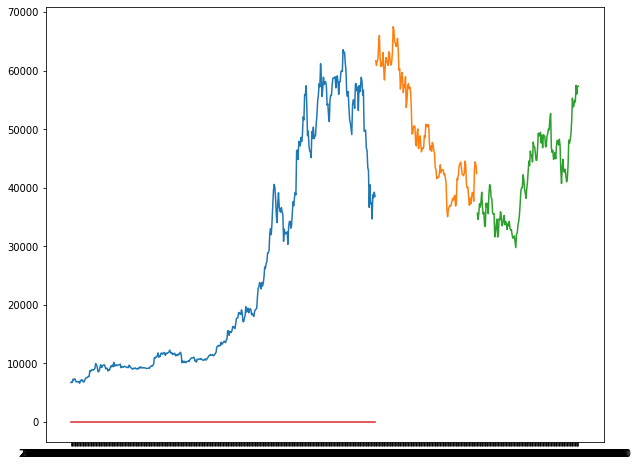

In [22]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       })

plt.plot(train_time,train['Close'])
plt.plot(test_time,test['Close'])
plt.plot(cv_time,cv['Close'])
plt.plot(train_time,est)

In [23]:
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['Close_std'] + cv['Close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 2398.671
MAPE on dev set = 4.525%


/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


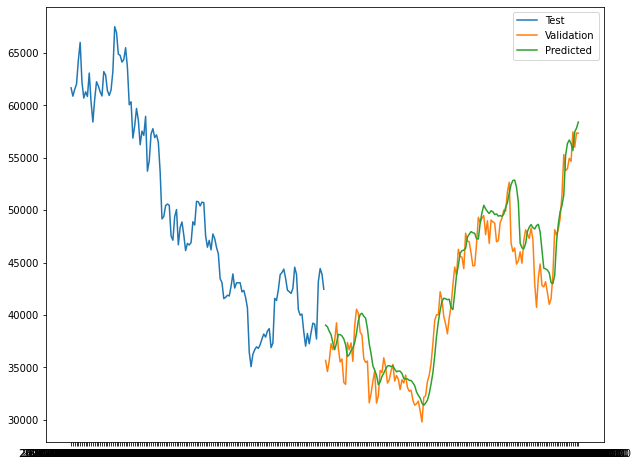

In [24]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       })


plt.plot(test_time,test['Close'], label = 'Test')
plt.plot(cv_time,cv['Close'], label = 'Validation')
plt.plot(cv_time,est_df['est'], label='Predicted')
plt.legend()

In [25]:
imp = list(zip(train[feature_pool], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('Compound_lag_1_x', 1.0053295e-05),
 ('Bitcoin_SVI_lag_1_x', 1.1646804e-05),
 ('Transactions_lag_1_x', 1.592121e-05),
 ('No. of Active Addresses_lag_1_x', 1.7152062e-05),
 ('No. of Unique Addresses_lag_1_x', 2.0738871e-05),
 ('Close_std', 2.5180923e-05),
 ('Volume_lag_1_x', 4.8750986e-05),
 ('Cryptocurrency_SVI_lag_1_x', 0.0017650373),
 ('Close_mean', 0.008146702),
 ('Close_lag_1_x', 0.98992944)]

In [26]:
## Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [27]:
param_label = 'n_estimators'
param_list = range(10, 100, 5)

param2_label = 'max_depth'
param2_list = [1, 2,3, 4, 5, 6, 7, 8, 9, 10]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic =time()
for param in param_list:
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,n_estimators,max_depth,rmse,mape_pct
0,10,1,2400.779965,4.468710
1,10,2,2309.278585,4.385146
2,10,3,2318.139208,4.391324
3,10,4,2311.742460,4.376638
4,10,5,2312.217874,4.378731
...,...,...,...,...
175,95,6,2396.165102,4.521792
176,95,7,2396.339113,4.522373
177,95,8,2396.316444,4.522302
178,95,9,2396.363157,4.522411


In [28]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2309.279
optimum params = 


(10, 2)

In [29]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 4.377%
optimum params = 


(10, 4)

In [30]:
## Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [31]:
param_label = 'learning_rate'
param_list = list(np.arange(0.001, 1, 0.005)) 


param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in (param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,1,2286.877291,4.471541
1,0.001,2,2286.877291,4.471541
2,0.001,3,2286.877291,4.471541
3,0.001,4,2286.877291,4.471541
4,0.001,5,2286.877291,4.471541
...,...,...,...,...
3995,0.996,16,2380.503051,4.517992
3996,0.996,17,2377.546176,4.512203
3997,0.996,18,2377.445986,4.511951
3998,0.996,19,2370.587040,4.544018


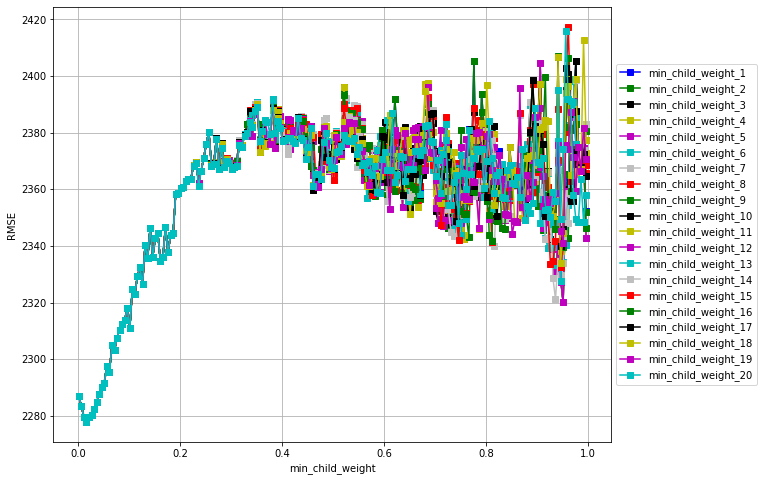

In [32]:
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param2_label)
ax.set_ylabel("RMSE")

plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [33]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 2277.756
optimum params = 


(0.016, 1)

In [34]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 4.386%
optimum params = 


(0.051000000000000004, 1)

In [35]:
## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [36]:
param_label = 'subsample'
param_list = list(np.arange(0.1, 1, 0.1))  

param2_label = 'gamma'
param2_list = list(np.arange(0.01, 1, 0.01))  

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in (param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,subsample,gamma,rmse,mape_pct
0,0.1,0.01,2290.502342,4.432879
1,0.1,0.02,2290.502342,4.432879
2,0.1,0.03,2290.502342,4.432879
3,0.1,0.04,2290.502342,4.432879
4,0.1,0.05,2290.502342,4.432879
...,...,...,...,...
886,0.9,0.95,2280.208512,4.420644
887,0.9,0.96,2280.208512,4.420644
888,0.9,0.97,2280.208512,4.420644
889,0.9,0.98,2280.208512,4.420644


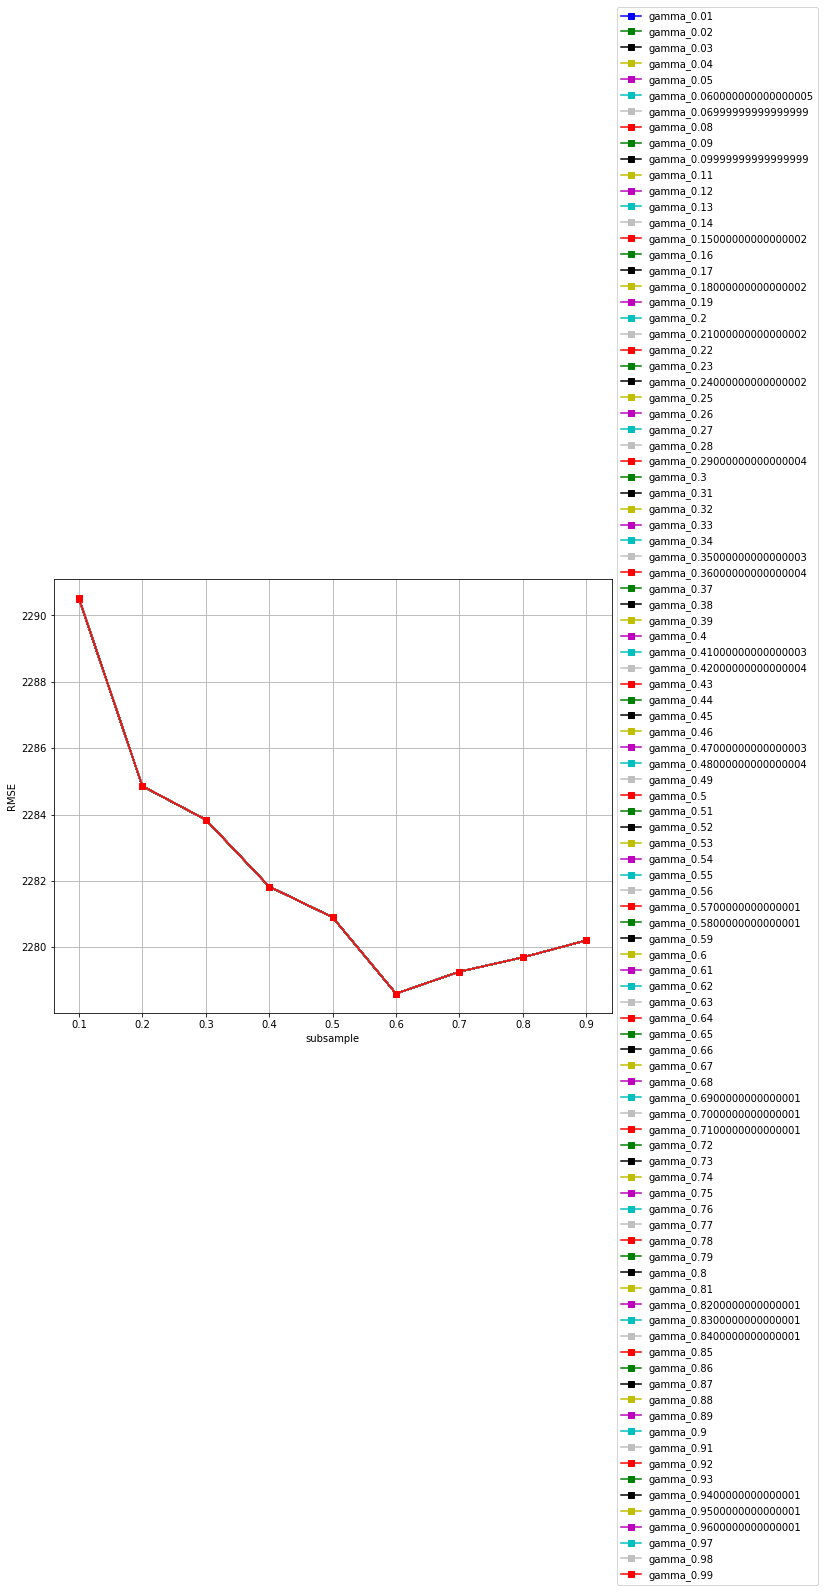

In [37]:
# Plot performance versus params
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")

plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [38]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 2278.606
optimum params = 


(0.6, 0.01)

In [39]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 4.418%
optimum params = 


(0.6, 0.01)

In [40]:
## Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [41]:


param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in (param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Close_mean'],
                                     cv['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   



/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,2283.359504,4.426447
1,0.5,0.6,2278.605774,4.418175
2,0.5,0.7,2278.605774,4.418175
3,0.5,0.8,2278.605774,4.418175
4,0.5,0.9,2278.605774,4.418175
5,0.5,1.0,2278.605774,4.418175
6,0.6,0.5,2278.605774,4.418175
7,0.6,0.6,2278.605774,4.418175
8,0.6,0.7,2278.605774,4.418175
9,0.6,0.8,2278.605774,4.418175


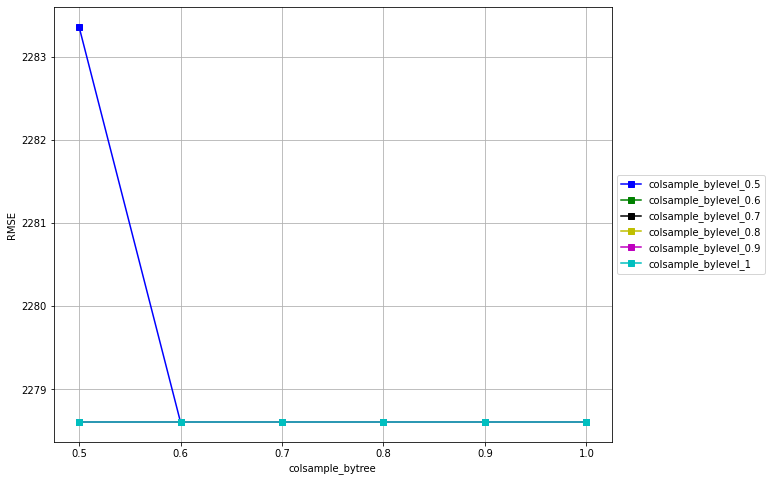

In [42]:
# Plot performance versus params
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [43]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 2278.606
optimum params = 


(0.5, 0.6)

In [44]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 4.418%
optimum params = 


(0.5, 0.6)

In [45]:
## Tuned params

In [46]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params
tuned_params

,param,original,after_tuning
0,n_estimators,100.000000,10.000000
1,max_depth,3.000000,2.000000
2,learning_rate,0.100000,0.016000
3,min_child_weight,1.000000,1.000000
4,subsample,1.000000,0.600000
5,colsample_bytree,1.000000,0.500000
6,colsample_bylevel,1.000000,0.600000
7,gamma,0.000000,0.010000
8,rmse,2398.670735,2278.605774
9,mape_pct,4.524656,4.418175


In [47]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_test_scaled, 
                             y_test, 
                             test['Close_mean'],
                             test['Close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 2671.802
MAPE on test set = 4.306%


/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [48]:
# Plot close over time
est_df = pd.DataFrame({'est': est, 
                       'y_test': y_test,
                      })

Text(0, 0.5, 'USD')

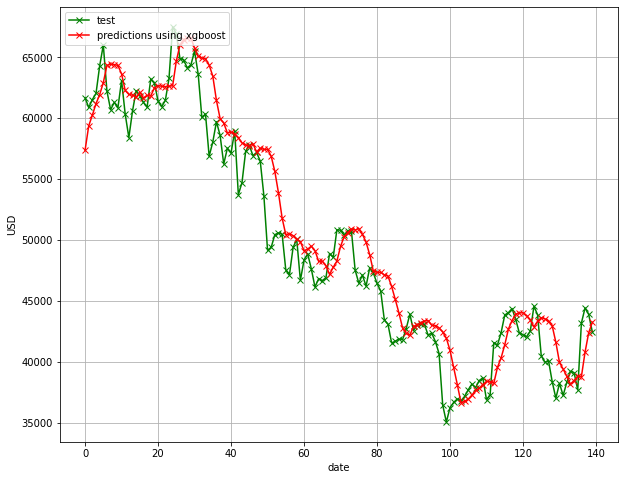

In [49]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8


ax = test.plot(y='Close', style='gx-', grid=True)
ax = est_df.plot(y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [50]:
# Prediction 

In [51]:
test_scaled = test_scaled[feature_pool]
test_scaled

,Compound_lag_1_x,Close_lag_1_x,Volume_lag_1_x,FundingRate_lag_1_x,Bitcoin_SVI_lag_1_x,Cryptocurrency_SVI_lag_1_x,No. of Active Addresses_lag_1_x,No. of Unique Addresses_lag_1_x,Transactions_lag_1_x,Compound_lag_2_x,...,Transactions_lag_4,Compound_lag_5,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5
0,0.161596,61673.9,860666768.9,0.023333,22.20,29.41,1017121.0,744869.0,297746.0,0.161596,...,-0.178465,-0.395954,2.000521,5.690783,-0.119887,0.759907,0.933841,0.050425,0.571628,-0.178465
1,0.161596,60878.4,402479983.2,0.030000,20.15,28.08,937355.0,674026.0,270052.0,0.161596,...,-0.956252,-0.395954,1.957462,2.211548,0.074525,0.582509,0.852071,-0.527440,-0.170459,-0.956252
2,-0.273200,61526.2,385518488.3,0.036667,16.92,26.64,823877.0,559522.0,215883.0,-0.273200,...,-2.477591,-2.623000,1.992527,2.082751,0.268937,0.302998,0.763539,-1.349532,-1.369899,-2.477591
3,0.000000,62027.8,624039708.7,0.033333,20.09,27.97,1003479.0,693822.0,285368.0,0.000000,...,-0.526101,-1.223655,2.019678,3.893959,0.171731,0.577317,0.845308,-0.048405,0.036906,-0.526101
4,0.509633,64285.4,702243691.5,0.010000,23.62,28.64,1077371.0,743673.0,312018.0,0.509633,...,0.222365,1.386713,2.141881,4.487799,-0.508711,0.882789,0.886501,0.486906,0.559100,0.222365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.106867,37706.7,388368905.7,0.006667,12.96,21.07,768705.0,583361.0,211164.0,0.106867,...,-2.610124,-0.676279,0.703190,2.104396,-0.605917,-0.039685,0.421092,-1.749226,-1.120184,-2.610124
136,0.135383,43179.8,564121052.5,-0.010000,16.20,24.83,981066.0,702483.0,270918.0,0.135383,...,-0.931930,-0.530215,0.999446,3.438967,-1.091947,0.240692,0.652259,-0.210776,0.127631,-0.931930
137,0.006329,44428.2,444858241.2,0.003333,17.67,29.34,1065354.0,722863.0,280634.0,0.006329,...,-0.659056,-1.191240,1.067021,2.533347,-0.703123,0.367899,0.929537,0.399849,0.341113,-0.659056
138,0.068437,43896.9,340460526.5,0.003333,15.61,26.33,1091796.0,731603.0,288657.0,0.068437,...,-0.433730,-0.873119,1.038262,1.740604,-0.703123,0.189635,0.744480,0.591408,0.432666,-0.433730


In [52]:
row = test_scaled[-5:].mean()
row = pd.DataFrame(row)
row = row.T
row

,Compound_lag_1_x,Close_lag_1_x,Volume_lag_1_x,FundingRate_lag_1_x,Bitcoin_SVI_lag_1_x,Cryptocurrency_SVI_lag_1_x,No. of Active Addresses_lag_1_x,No. of Unique Addresses_lag_1_x,Transactions_lag_1_x,Compound_lag_2_x,...,Transactions_lag_4,Compound_lag_5,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5
0,0.085268,42333.58,4.124709e+08,0.002667,15.256,25.13,983673.8,688301.6,263923.4,0.085268,...,-1.128374,-0.786906,0.953641,2.287414,-0.722564,0.159002,0.670703,-0.191884,-0.020921,-1.128374


In [53]:
close_mean = test['Close_mean'][-5:].mean()
close_std = test['Close_std'][-5:].mean()

In [54]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=10,
                     max_depth=2,
                     learning_rate=0.016,
                     min_child_weight=1,
                     subsample=0.6,
                     colsample_bytree=0.5,
                     colsample_bylevel=0.6,
                     gamma=0.1)
model.fit(X_train_cv_scaled,y_train_cv_scaled)

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.016, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [55]:
est_scaled = model.predict(row)
est = est_scaled * close_std + close_mean
est[0]

40746.168

Reality: Bitcoin's market dominance fell 0.11 percent to 43.06 percent and the currency was trading at $41,430.77 on the morning of March 4.4 Mar 2022
